In [29]:
"""VGG16 model for Keras.
# Reference
- [Very Deep Convolutional Networks for Large-Scale Image
Recognition](https://arxiv.org/abs/1409.1556)
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

from tensorflow.python.keras._impl.keras import backend as K
from tensorflow.python.keras._impl.keras.applications.imagenet_utils import _obtain_input_shape
from tensorflow.python.keras._impl.keras.applications.imagenet_utils import decode_predictions
from tensorflow.python.keras._impl.keras.applications.imagenet_utils import preprocess_input
from tensorflow.python.keras._impl.keras.engine.network import get_source_inputs
from tensorflow.python.keras._impl.keras.layers import Conv2D
from tensorflow.python.keras._impl.keras.layers import Dense
from tensorflow.python.keras._impl.keras.layers import Flatten
from tensorflow.python.keras._impl.keras.layers import GlobalAveragePooling2D
from tensorflow.python.keras._impl.keras.layers import GlobalMaxPooling2D
from tensorflow.python.keras._impl.keras.layers import Input
from tensorflow.python.keras._impl.keras.layers import MaxPooling2D
from tensorflow.python.keras._impl.keras.models import Model
from tensorflow.python.keras._impl.keras.utils import layer_utils
from tensorflow.python.keras._impl.keras.utils.data_utils import get_file
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.util.tf_export import tf_export


WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'


class VGG16(object):

 @property
 def lastFC(self):
  if self._prelast_layer == None:
    raise ValueError('include_top argument needs to be True')
  return self._prelast_layer

 @property
 def model(self):
  return self._model

 def __init__(self, include_top=True,
          weights='imagenet',
          input_tensor=None,
          input_shape=None,
          pooling=None,
          classes=1000):

  if not (weights in {'imagenet', None} or os.path.exists(weights)):
    raise ValueError('The `weights` argument should be either '
                     '`None` (random initialization), `imagenet` '
                     '(pre-training on ImageNet), '
                     'or the path to the weights file to be loaded.')

  if weights == 'imagenet' and include_top and classes != 1000:
    raise ValueError('If using `weights` as imagenet with `include_top`'
                     ' as true, `classes` should be 1000')
  # Determine proper input shape
  input_shape = _obtain_input_shape(
      input_shape,
      default_size=224,
      min_size=48,
      data_format=K.image_data_format(),
      require_flatten=include_top,
      weights=weights)

  if input_tensor is None:
    img_input = Input(shape=input_shape)
  else:
    if not K.is_keras_tensor(input_tensor):
      img_input = Input(tensor=input_tensor, shape=input_shape)
    else:
      img_input = input_tensor
    
  self._last_layer = None

  # Block 1
  x = Conv2D(
      64, (3, 3), activation='relu', padding='same', name='block1_conv1')(
          img_input)
  x = Conv2D(
      64, (3, 3), activation='relu', padding='same', name='block1_conv2')(
          x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

  # Block 2
  x = Conv2D(
      128, (3, 3), activation='relu', padding='same', name='block2_conv1')(
          x)
  x = Conv2D(
      128, (3, 3), activation='relu', padding='same', name='block2_conv2')(
          x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

  # Block 3
  x = Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3_conv1')(
          x)
  x = Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3_conv2')(
          x)
  x = Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3_conv3')(
          x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

  # Block 4
  x = Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block4_conv1')(
          x)
  x = Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block4_conv2')(
          x)
  x = Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block4_conv3')(
          x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

  # Block 5
  x = Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5_conv1')(
          x)
  x = Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5_conv2')(
          x)
  x = Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5_conv3')(
          x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

  if include_top:
    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    # to fetch the second last layer
    self._prelast_layer = x
    x = Dense(classes, activation='softmax', name='predictions')(x)
  else:
    self._prelast_layer = x
    if pooling == 'avg':
      x = GlobalAveragePooling2D()(x)
    elif pooling == 'max':
      x = GlobalMaxPooling2D()(x)

  # Ensure that the model takes into account
  # any potential predecessors of `input_tensor`.
  if input_tensor is not None:
    inputs = get_source_inputs(input_tensor)
  else:
    inputs = img_input
  # Create model.
  model = Model(inputs, x, name='vgg16')

  # load weights
  if weights == 'imagenet':
    if include_top:
      weights_path = get_file(
          'vgg16_weights_tf_dim_ordering_tf_kernels.h5',
          WEIGHTS_PATH,
          cache_subdir='models',
          file_hash='64373286793e3c8b2b4e3219cbf3544b')
    else:
      weights_path = get_file(
          'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
          WEIGHTS_PATH_NO_TOP,
          cache_subdir='models',
          file_hash='6d6bbae143d832006294945121d1f1fc')
    model.load_weights(weights_path)
    if K.backend() == 'theano':
      layer_utils.convert_all_kernels_in_model(model)

    if K.image_data_format() == 'channels_first':
      if include_top:
        maxpool = model.get_layer(name='block5_pool')
        shape = maxpool.output_shape[1:]
        dense = model.get_layer(name='fc1')
        layer_utils.convert_dense_weights_data_format(dense, shape,
                                                      'channels_first')

  elif weights is not None:
    model.load_weights(weights)

  self._model = model

In [104]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

vgg16 = VGG16()
model = vgg16.model

inp = model.input                                           # input placeholder
outputs = [model.get_layer('fc2').output,model.get_layer('predictions').output]          # all layer outputs
functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function

def imagesEmb(img_path):
    # load an image from file
    image = load_img(img_path, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # predict the probability across all output classes
    # Testing
    layer_outs = functor([image, 1.])
    #print(yhat)
    #print("last layer",lc)
    # convert the probabilities to class labels
    label = decode_predictions(layer_outs[1])
    # retrieve the most likely result, e.g. highest probability
    label = label[0][0]
    # print the classification
    #print('%s (%.2f%%)' % (label[1], label[2]*100))
    
    return layer_outs


In [42]:
""" Getting embeddings from last layer(1000D) and pre-last(4096D) layer for all the images"""
import numpy as np

data_path = "datasets/s_imagenet/"
emb_last = np.zeros((2000,1000))
emb_pre_last = np.zeros((2000,4096))

img2idx = dict()
count = 0

with open("img2id.txt","w") as f:
  for d in os.listdir(data_path):
    for file in os.listdir(os.path.join(data_path, d)):
        img_path = os.path.join(data_path,d,file)
        if os.path.isfile(img_path):
            img2idx[file] = count
            f.write("{}\t{}\n".format(file.split(".")[0],count))
            embs = imagesEmb(img_path)
            emb_pre_last[count] = embs[0]
            emb_last[count] = embs[1]
            count = count+1

np.savetxt("last_emb.txt", emb_last, comments="Last layer emebedding of VGG16")
np.savetxt("prelast_emb.txt", emb_pre_last, comments="Pre Last layer emebedding of VGG16")

In [113]:
import json
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib import offsetbox

CLASS_INDEX_PATH = "imagenet_class_index.json"

idx2img = {v:k for k,v in img2idx.items()}

# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure(figsize=(100,100))
    ax = plt.subplot(111)
    with open(CLASS_INDEX_PATH) as f:
      CLASS_INDEX = json.load(f)
      CLASS_INDEX = {k:v for k,v in CLASS_INDEX.values()}
      for i in range(X.shape[0]):
        #print(idx2img[i])
        #plt.scatter(X[i, 0], X[i, 1],
        #         color=plt.cm.gist_ncar((i%100) / 100.))
        plt.text(X[i, 0], X[i, 1], CLASS_INDEX[str(idx2img[i]).split('_')[0]],
                 color=plt.cm.gist_ncar((i%200) / 200.),
                 fontdict={'weight': 'bold', 'size': 9})

    """if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)"""
    #plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
        
    plt.savefig("imgnet-tsne.png")
        
        


In [56]:
# t-SNE embedding of the imagenet 100 class dataset
print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(emb_last)


Computing t-SNE embedding


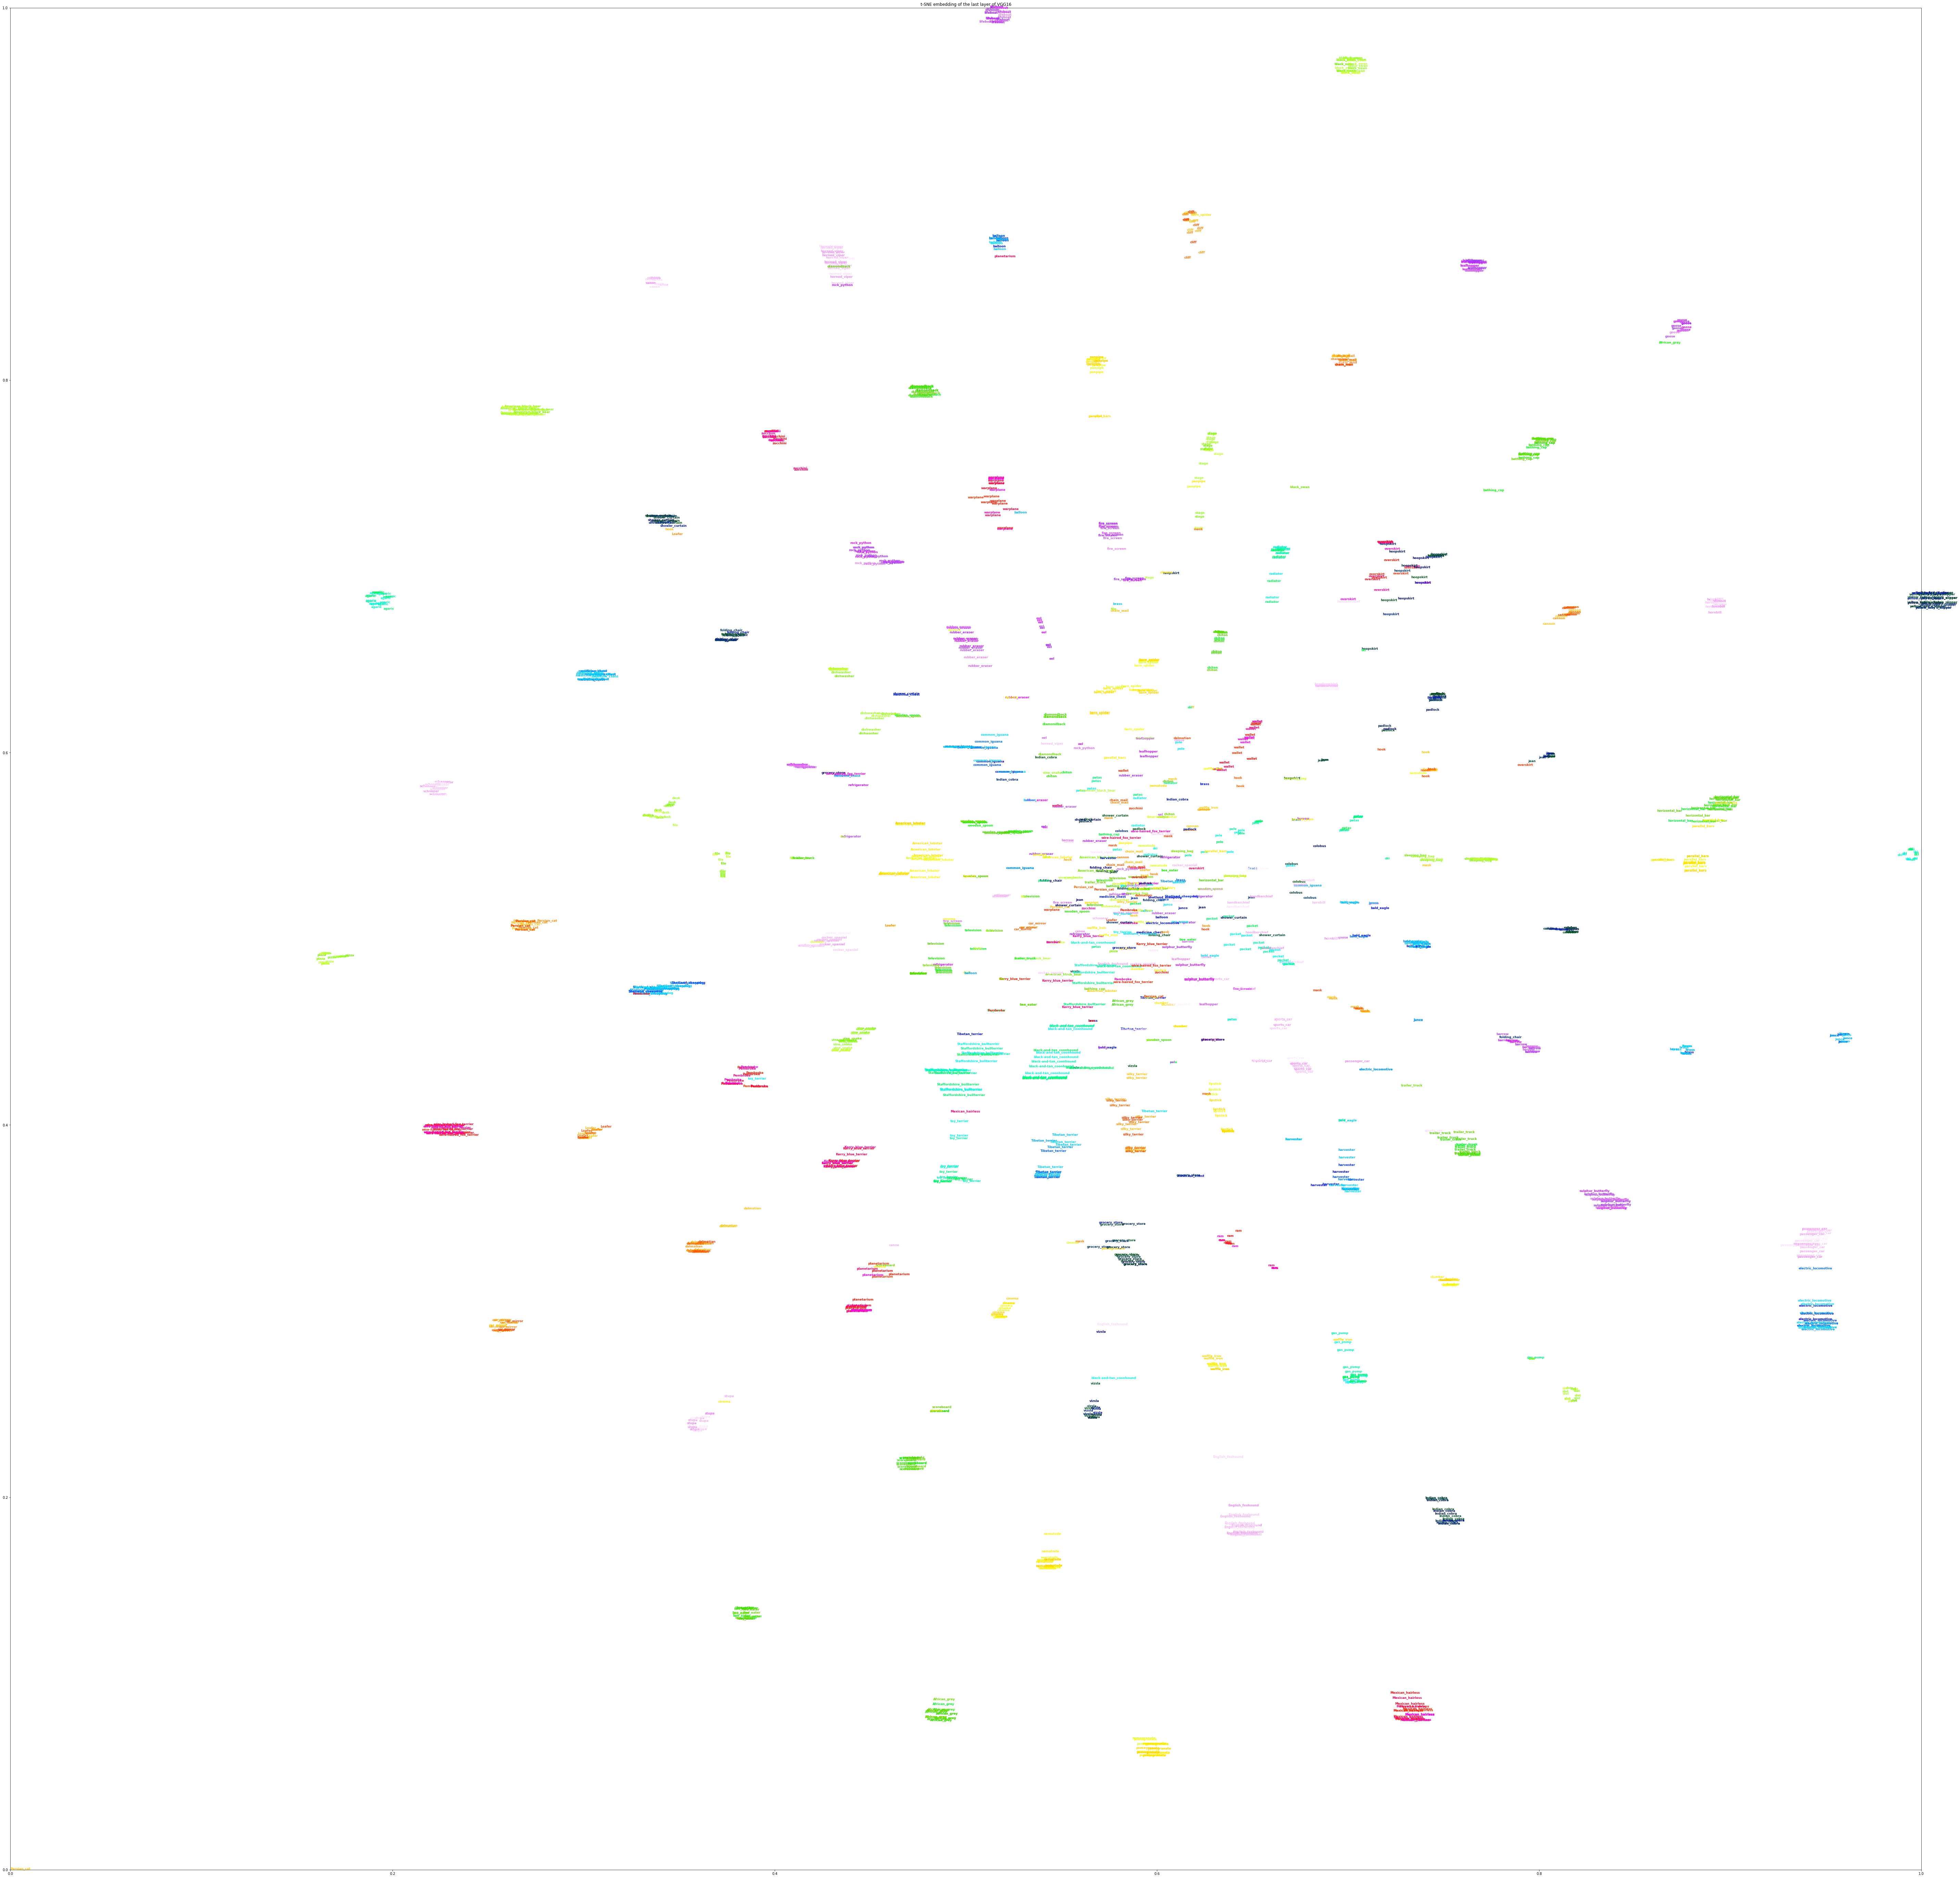

In [114]:

plot_embedding(X_tsne,
               "t-SNE embedding of the last layer of VGG16")

plt.show()

In [92]:
# t-SNE embedding of the imagenet 100 class dataset
print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne_1 = tsne.fit_transform(emb_pre_last)

Computing t-SNE embedding


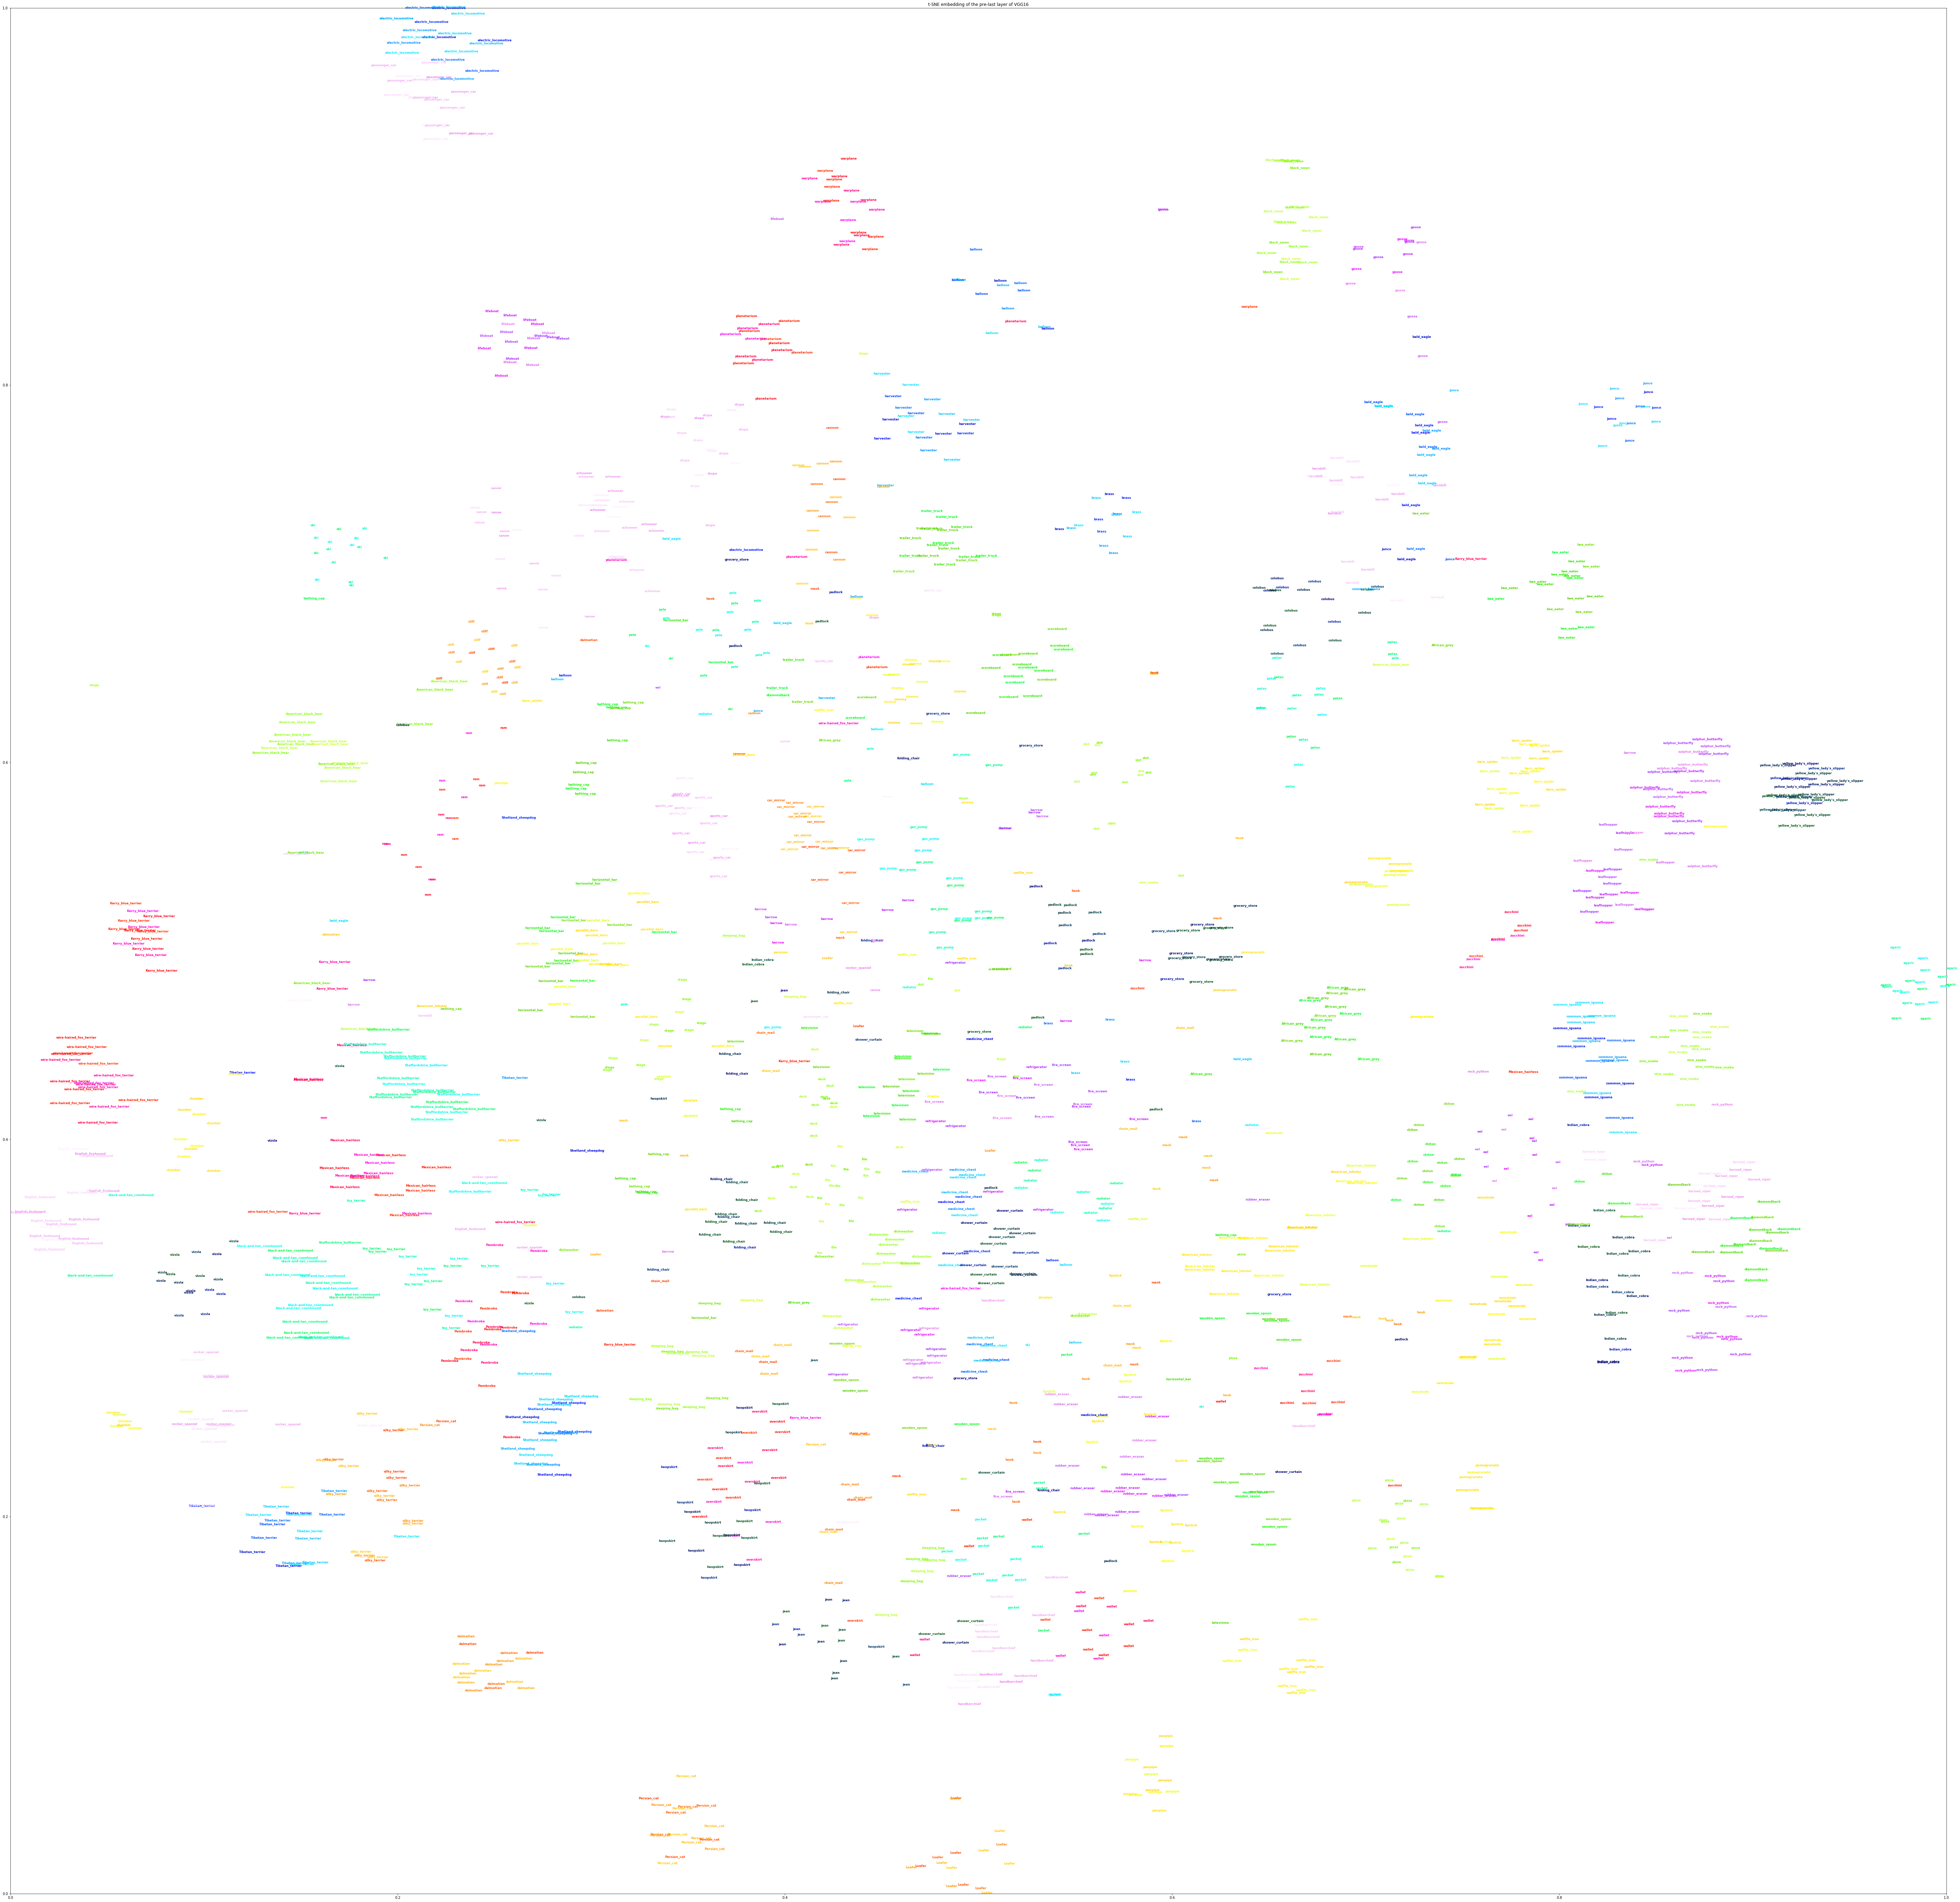

In [115]:

plot_embedding(X_tsne_1,
               "t-SNE embedding of the pre-last layer of VGG16")
plt.show()